In [49]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [50]:
# 1. Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú ÏÑ§Ï†ï
base_path = r'D:\my_projects\calmman-facial-classification\data\processed'
teasing_path = os.path.join(base_path, 'teasing')
non_teasing_path = os.path.join(base_path, 'non_teasing')

# 2. ÌÅ¥ÎûòÏä§ Ï†ïÏùò (Ïù¥ÏßÑÎ∂ÑÎ•ò)
classes = ['non_teasing', 'teasing']  # 0: ÏïΩÏò¨Î¶¨ÏßÄ ÏïäÏùå, 1: ÏïΩÏò¨Î¶º
class_to_index = {cls: idx for idx, cls in enumerate(classes)}

print(f"ÌÅ¥ÎûòÏä§ Îß§Ìïë: {class_to_index}")
print(f"ÏïΩÏò¨Î¶¨Í∏∞ Ìè¥Îçî Ï°¥Ïû¨: {os.path.exists(teasing_path)}")
print(f"ÎπÑÏïΩÏò¨Î¶¨Í∏∞ Ìè¥Îçî Ï°¥Ïû¨: {os.path.exists(non_teasing_path)}")

ÌÅ¥ÎûòÏä§ Îß§Ìïë: {'non_teasing': 0, 'teasing': 1}
ÏïΩÏò¨Î¶¨Í∏∞ Ìè¥Îçî Ï°¥Ïû¨: True
ÎπÑÏïΩÏò¨Î¶¨Í∏∞ Ìè¥Îçî Ï°¥Ïû¨: True


In [51]:
import cv2
import numpy as np
from tqdm import tqdm
import os
from PIL import Image

# 3. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ (Í∞úÏÑ†Îêú Î≤ÑÏ†Ñ)
img_size = 224
X = []
y = []

# Ïù¥ÎØ∏ÏßÄ ÌôïÏû•Ïûê Ï†ïÏùò
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

def load_images_from_folder_robust(folder_path, label):
    """Í∞ïÌôîÎêú Ïù¥ÎØ∏ÏßÄ Î°úÎî© Ìï®Ïàò"""
    images = []
    labels = []
    failed_files = []
    
    if not os.path.exists(folder_path):
        print(f"Í≤ΩÍ≥†: {folder_path} Ìè¥ÎçîÍ∞Ä Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏäµÎãàÎã§.")
        return images, labels, failed_files
    
    file_list = [f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)]
    
    for fname in tqdm(file_list, desc=f"Loading {os.path.basename(folder_path)}"):
        img_path = os.path.join(folder_path, fname)
        
        try:
            # Î∞©Î≤ï 1: OpenCVÎ°ú ÏãúÎèÑ
            img = cv2.imread(img_path)
            
            if img is None:
                # Î∞©Î≤ï 2: PILÎ°ú ÏãúÎèÑ (ÌïúÍ∏Ä Í≤ΩÎ°ú Î¨∏Ï†ú Ìï¥Í≤∞)
                pil_img = Image.open(img_path)
                img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
            
            if img is None:
                raise Exception("Ïù¥ÎØ∏ÏßÄ Î°úÎìú Ïã§Ìå®")
            
            # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ ÌôïÏù∏
            if img.shape[0] == 0 or img.shape[1] == 0:
                raise Exception("Îπà Ïù¥ÎØ∏ÏßÄ")
            
            # BGR to RGB Î≥ÄÌôò
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # ÌÅ¨Í∏∞ Ï°∞Ï†ï
            img = cv2.resize(img, (img_size, img_size))
            
            # Ï†ïÍ∑úÌôî
            img = img.astype('float32') / 255.0
            
            images.append(img)
            labels.append(label)
            
        except Exception as e:
            failed_files.append(fname)
            print(f"Ïã§Ìå®: {fname} - {str(e)}")
            continue
    
    return images, labels, failed_files

# ÎπÑÏïΩÏò¨Î¶¨Í∏∞ Ïù¥ÎØ∏ÏßÄ Î°úÎìú (ÎùºÎ≤®: 0)
X_non_teasing, y_non_teasing, failed_non_teasing = load_images_from_folder_robust(non_teasing_path, 0)

# ÏïΩÏò¨Î¶¨Í∏∞ Ïù¥ÎØ∏ÏßÄ Î°úÎìú (ÎùºÎ≤®: 1)
X_teasing, y_teasing, failed_teasing = load_images_from_folder_robust(teasing_path, 1)

# Îç∞Ïù¥ÌÑ∞ Ìï©ÏπòÍ∏∞
X = X_non_teasing + X_teasing
y = y_non_teasing + y_teasing

print(f"\n=== Î°úÎî© Í≤∞Í≥º ===")
print(f"Ï¥ù Ïù¥ÎØ∏ÏßÄ Ïàò: {len(X)}")
print(f"ÎπÑÏïΩÏò¨Î¶¨Í∏∞ Ïù¥ÎØ∏ÏßÄ: {len(X_non_teasing)}")
print(f"ÏïΩÏò¨Î¶¨Í∏∞ Ïù¥ÎØ∏ÏßÄ: {len(X_teasing)}")
print(f"Ïã§Ìå®Ìïú ÎπÑÏïΩÏò¨Î¶¨Í∏∞ ÌååÏùº: {len(failed_non_teasing)}Í∞ú")
print(f"Ïã§Ìå®Ìïú ÏïΩÏò¨Î¶¨Í∏∞ ÌååÏùº: {len(failed_teasing)}Í∞ú")

if failed_non_teasing:
    print(f"Ïã§Ìå®Ìïú ÎπÑÏïΩÏò¨Î¶¨Í∏∞ ÌååÏùºÎì§: {failed_non_teasing}")
if failed_teasing:
    print(f"Ïã§Ìå®Ìïú ÏïΩÏò¨Î¶¨Í∏∞ ÌååÏùºÎì§: {failed_teasing}")

Loading non_teasing:   0%|          | 0/125 [00:00<?, ?it/s]

Loading teasing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 1200.57it/s]


=== Î°úÎî© Í≤∞Í≥º ===
Ï¥ù Ïù¥ÎØ∏ÏßÄ Ïàò: 160
ÎπÑÏïΩÏò¨Î¶¨Í∏∞ Ïù¥ÎØ∏ÏßÄ: 125
ÏïΩÏò¨Î¶¨Í∏∞ Ïù¥ÎØ∏ÏßÄ: 35
Ïã§Ìå®Ìïú ÎπÑÏïΩÏò¨Î¶¨Í∏∞ ÌååÏùº: 0Í∞ú
Ïã§Ìå®Ìïú ÏïΩÏò¨Î¶¨Í∏∞ ÌååÏùº: 0Í∞ú


In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_minority_class(X_list, y_list, target_ratio=0.8):
    """
    ÏÜåÏàò ÌÅ¥ÎûòÏä§Î•º Îã§Ïàò ÌÅ¥ÎûòÏä§Ïùò ÏùºÏ†ï ÎπÑÏú®ÍπåÏßÄ Ï¶ùÍ∞ï
    target_ratio: Îã§Ïàò ÌÅ¥ÎûòÏä§ ÎåÄÎπÑ ÏÜåÏàò ÌÅ¥ÎûòÏä§ ÎπÑÏú® (0.8 = 80%)
    """
    
    # ÌÅ¥ÎûòÏä§Î≥Ñ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
    class_0_indices = [i for i, label in enumerate(y_list) if label == 0]
    class_1_indices = [i for i, label in enumerate(y_list) if label == 1]
    
    class_0_data = [X_list[i] for i in class_0_indices]
    class_1_data = [X_list[i] for i in class_1_indices]
    
    print(f"Ï¶ùÍ∞ï Ï†Ñ:")
    print(f"  ÎπÑÏïΩÏò¨Î¶¨Í∏∞ (ÌÅ¥ÎûòÏä§ 0): {len(class_0_data)}Í∞ú")
    print(f"  ÏïΩÏò¨Î¶¨Í∏∞ (ÌÅ¥ÎûòÏä§ 1): {len(class_1_data)}Í∞ú")
    print(f"  Î∂àÍ∑†Ìòï ÎπÑÏú®: {len(class_1_data)/len(class_0_data):.2f}")
    
    # Î™©Ìëú Í∞úÏàò Í≥ÑÏÇ∞
    target_count = int(len(class_0_data) * target_ratio)
    
    if len(class_1_data) >= target_count:
        print(f"Ï¶ùÍ∞ï Î∂àÌïÑÏöî: Ïù¥ÎØ∏ Î™©Ìëú ÎπÑÏú®({target_ratio})ÏùÑ Ï∂©Ï°±Ìï©ÎãàÎã§.")
        return X_list, y_list
    
    # Ï¶ùÍ∞ïÍ∏∞ ÏÑ§Ï†ï (ÏïΩÏò¨Î¶¨Í∏∞Ïóê Ï†ÅÌï©Ìïú Ï¶ùÍ∞ï)
    datagen = ImageDataGenerator(
        rotation_range=20,           # ÌöåÏ†Ñ (ÏñºÍµ¥ Í∞ÅÎèÑ Î≥ÄÌôî)
        width_shift_range=0.15,      # Í∞ÄÎ°ú Ïù¥Îèô
        height_shift_range=0.15,     # ÏÑ∏Î°ú Ïù¥Îèô
        horizontal_flip=True,        # Ï¢åÏö∞ Î∞òÏ†Ñ
        zoom_range=0.15,             # ÌôïÎåÄ/Ï∂ïÏÜå
        brightness_range=[0.8, 1.2], # Î∞ùÍ∏∞ Ï°∞Ï†ï
        fill_mode='nearest'          # Îπà Í≥µÍ∞Ñ Ï±ÑÏö∞Í∏∞
    )
    
    # ÌïÑÏöîÌïú Ï¶ùÍ∞ï Ïù¥ÎØ∏ÏßÄ Í∞úÏàò
    need_count = target_count - len(class_1_data)
    
    print(f"Î™©Ìëú Í∞úÏàò: {target_count}Í∞ú")
    print(f"Ï¶ùÍ∞ïÌï† Ïù¥ÎØ∏ÏßÄ: {need_count}Í∞ú")
    
    augmented_images = []
    augmented_labels = []
    
    # ÏßÑÌñâÎ•† ÌëúÏãúÏôÄ Ìï®Íªò Ï¶ùÍ∞ï
    for i in tqdm(range(need_count), desc="Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Ï§ë"):
        # Í∏∞Ï°¥ ÏïΩÏò¨Î¶¨Í∏∞ Ïù¥ÎØ∏ÏßÄ Ï§ë ÎûúÎç§ ÏÑ†ÌÉù
        base_img = class_1_data[i % len(class_1_data)]
        
        # Î∞∞Ïπò Ï∞®Ïõê Ï∂îÍ∞Ä (ImageDataGenerator ÏûÖÎ†• ÌòïÏãù)
        img_batch = np.expand_dims(base_img, 0)
        
        # Ï¶ùÍ∞ï Ï†ÅÏö©
        aug_iter = datagen.flow(img_batch, batch_size=1)
        aug_img = next(aug_iter)[0]
        
        # Í∞í Î≤îÏúÑ ÌôïÏù∏ Î∞è Ï†ïÍ∑úÌôî Ïú†ÏßÄ
        aug_img = np.clip(aug_img, 0.0, 1.0)
        
        augmented_images.append(aug_img)
        augmented_labels.append(1)
    
    # ÏõêÎ≥∏ + Ï¶ùÍ∞ï Îç∞Ïù¥ÌÑ∞ Ìï©ÏπòÍ∏∞
    final_X = class_0_data + class_1_data + augmented_images
    final_y = [0] * len(class_0_data) + [1] * len(class_1_data) + augmented_labels
    
    print(f"\nÏ¶ùÍ∞ï ÌõÑ:")
    print(f"  ÎπÑÏïΩÏò¨Î¶¨Í∏∞ (ÌÅ¥ÎûòÏä§ 0): {len(class_0_data)}Í∞ú")
    print(f"  ÏïΩÏò¨Î¶¨Í∏∞ (ÌÅ¥ÎûòÏä§ 1): {len(class_1_data) + len(augmented_images)}Í∞ú")
    print(f"  Ï¥ù Ïù¥ÎØ∏ÏßÄ Ïàò: {len(final_X)}Í∞ú")
    print(f"  ÏµúÏ¢Ö ÎπÑÏú®: {(len(class_1_data) + len(augmented_images))/len(class_0_data):.2f}")
    
    return final_X, final_y

# Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Ïã§Ìñâ
X, y = augment_minority_class(X, y, target_ratio=0.8)

Ï¶ùÍ∞ï Ï†Ñ:
  ÎπÑÏïΩÏò¨Î¶¨Í∏∞ (ÌÅ¥ÎûòÏä§ 0): 125Í∞ú
  ÏïΩÏò¨Î¶¨Í∏∞ (ÌÅ¥ÎûòÏä§ 1): 35Í∞ú
  Î∂àÍ∑†Ìòï ÎπÑÏú®: 0.28
Î™©Ìëú Í∞úÏàò: 100Í∞ú
Ï¶ùÍ∞ïÌï† Ïù¥ÎØ∏ÏßÄ: 65Í∞ú


Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 65/65 [00:00<00:00, 275.23it/s]


Ï¶ùÍ∞ï ÌõÑ:
  ÎπÑÏïΩÏò¨Î¶¨Í∏∞ (ÌÅ¥ÎûòÏä§ 0): 125Í∞ú
  ÏïΩÏò¨Î¶¨Í∏∞ (ÌÅ¥ÎûòÏä§ 1): 100Í∞ú
  Ï¥ù Ïù¥ÎØ∏ÏßÄ Ïàò: 225Í∞ú
  ÏµúÏ¢Ö ÎπÑÏú®: 0.80


In [53]:
# 4. NumPy Î∞∞Ïó¥ Î≥ÄÌôò
X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨: {np.bincount(y)}")

# 5. ÌïôÏäµ/Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† (Í≥ÑÏ∏µÏ†Å ÏÉòÌîåÎßÅ)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: {X_train.shape}, Î†àÏù¥Î∏î: {y_train.shape}")
print(f"Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: {X_val.shape}, Î†àÏù¥Î∏î: {y_val.shape}")
print(f"ÌõàÎ†® ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨: {np.bincount(y_train)}")
print(f"Í≤ÄÏ¶ù ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨: {np.bincount(y_val)}")

X shape: (225, 224, 224, 3)
y shape: (225,)
ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨: [125 100]
ÌõàÎ†® Îç∞Ïù¥ÌÑ∞: (180, 224, 224, 3), Î†àÏù¥Î∏î: (180,)
Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: (45, 224, 224, 3), Î†àÏù¥Î∏î: (45,)
ÌõàÎ†® ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨: [100  80]
Í≤ÄÏ¶ù ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨: [25 20]


In [27]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

# # EfficientNetB0 Î∞±Î≥∏ Î°úÎìú (ImageNet ÏÇ¨Ï†ÑÌïôÏäµ ÏÇ¨Ïö©)
# base_model = EfficientNetB0(
#     include_top=False, 
#     weights='imagenet', 
#     input_shape=(224, 224, 3)
# )

# # ÌäπÏßï Ï∂îÏ∂úÏ∏µ
# x = GlobalAveragePooling2D()(base_model.output)
# x = Dropout(0.3)(x)

# # Ïù¥ÏßÑÎ∂ÑÎ•òÎ•º ÏúÑÌïú Ï∂úÎ†•Ï∏µ
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
# output = Dense(1, activation='sigmoid', name='teasing_output')(x)

# # Î™®Îç∏ Ï†ïÏùò
# model = Model(inputs=base_model.input, outputs=output)

# print("Î™®Îç∏Ïù¥ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§.")

In [55]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

# EfficientNetB0 Î∞±Î≥∏ Î°úÎìú Î∞è ÎèôÍ≤∞
base_model = EfficientNetB0(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224, 224, 3)
)

# Î∞±Î≥∏ ÎèôÍ≤∞ (Í∞ÄÏ§ëÏπò ÏóÖÎç∞Ïù¥Ìä∏ ÏïàÌï®)
base_model.trainable = False

# Î∂ÑÎ•òÍ∏∞ Ìó§ÎìúÎßå Ï∂îÍ∞Ä
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

print("Î™®Îç∏Ïù¥ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§.")

Î™®Îç∏Ïù¥ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§.


In [26]:
# model.summary()

In [56]:
# Î™®Îç∏ Ïª¥ÌååÏùº
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Î™®Îç∏ Ïª¥ÌååÏùº ÏôÑÎ£å")

Î™®Îç∏ Ïª¥ÌååÏùº ÏôÑÎ£å


In [38]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

class TQDMProgressBar(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epochs = self.params['epochs']
        self.pbar = tqdm(total=self.params['steps'], desc=f"Epoch {epoch+1}/{self.epochs}", unit='step')

    def on_batch_end(self, batch, logs=None):
        self.pbar.update(1)

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.close()

# ÏΩúÎ∞± ÏÑ§Ï†ï
callbacks = [
    TQDMProgressBar(),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_teasing_model.h5', monitor='val_accuracy', save_best_only=True)
]

print("ÏΩúÎ∞± ÏÑ§Ï†ï ÏôÑÎ£å")

ÏΩúÎ∞± ÏÑ§Ï†ï ÏôÑÎ£å


In [57]:
# Î™®Îç∏ ÌïôÏäµ
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

print("ÌïôÏäµ ÏôÑÎ£å!")

Epoch 1/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 1/20


Epoch 1/20:  17%|‚ñà‚ñã        | 1/6 [00:03<00:17,  3.45s/step]

1/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 3s/step - accuracy: 0.3438 - loss: 0.7486

Epoch 1/20:  33%|‚ñà‚ñà‚ñà‚ñé      | 2/6 [00:03<00:06,  1.55s/step]

2/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 221ms/step - accuracy: 0.3984 - loss: 0.7497

Epoch 1/20:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 3/6 [00:03<00:02,  1.06step/s]

3/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 223ms/step - accuracy: 0.4184 - loss: 0.7601

Epoch 1/20:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 4/6 [00:04<00:01,  1.50step/s]

4/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 227ms/step - accuracy: 0.4349 - loss: 0.7611

Epoch 1/20:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 5/6 [00:04<00:00,  1.96step/s]

5/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 229ms/step - accuracy: 0.4442 - loss: 0.7592

Epoch 1/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:04<00:00,  2.56step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 215ms/step - accuracy: 0.4498 - loss: 0.7582

Epoch 1/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:05<00:00,  1.03step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 476ms/step - accuracy: 0.4538 - loss: 0.7575 - val_accuracy: 0.4444 - val_loss: 0.7193



Epoch 2/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 2/20


Epoch 2/20:  17%|‚ñà‚ñã        | 1/6 [00:00<00:01,  4.02step/s]

1/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 250ms/step - accuracy: 0.5312 - loss: 0.7081

Epoch 2/20:  33%|‚ñà‚ñà‚ñà‚ñé      | 2/6 [00:00<00:00,  4.27step/s]

2/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 222ms/step - accuracy: 0.5078 - loss: 0.7117

Epoch 2/20:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 3/6 [00:00<00:00,  4.37step/s]

3/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 223ms/step - accuracy: 0.4878 - loss: 0.7118

Epoch 2/20:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 4/6 [00:00<00:00,  4.42step/s]

4/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 223ms/step - accuracy: 0.4714 - loss: 0.7118

Epoch 2/20:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 5/6 [00:01<00:00,  4.42step/s]

5/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 223ms/step - accuracy: 0.4733 - loss: 0.7093

Epoch 2/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:01<00:00,  5.04step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 208ms/step - accuracy: 0.4750 - loss: 0.7084

Epoch 2/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:01<00:00,  3.62step/s]


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 309ms/step - accuracy: 0.4762 - loss: 0.7078 - val_accuracy: 0.5556 - val_loss: 0.6979


Epoch 3/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 3/20


Epoch 3/20:  17%|‚ñà‚ñã        | 1/6 [00:00<00:01,  4.04step/s]

1/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 247ms/step - accuracy: 0.6562 - loss: 0.6682

Epoch 3/20:  33%|‚ñà‚ñà‚ñà‚ñé      | 2/6 [00:00<00:00,  4.17step/s]

2/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 235ms/step - accuracy: 0.6250 - loss: 0.6759

Epoch 3/20:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 3/6 [00:00<00:00,  4.23step/s]

3/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 233ms/step - accuracy: 0.5938 - loss: 0.6862

Epoch 3/20:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 4/6 [00:00<00:00,  4.24step/s]

4/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 234ms/step - accuracy: 0.5859 - loss: 0.6876

Epoch 3/20:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 5/6 [00:01<00:00,  4.19step/s]

5/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 237ms/step - accuracy: 0.5763 - loss: 0.6908

Epoch 3/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:01<00:00,  4.69step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 222ms/step - accuracy: 0.5719 - loss: 0.6921

Epoch 3/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:01<00:00,  3.48step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 298ms/step - accuracy: 0.5688 - loss: 0.6931 - val_accuracy: 0.5556 - val_loss: 0.6871



Epoch 4/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 4/20


Epoch 4/20:  17%|‚ñà‚ñã        | 1/6 [00:00<00:01,  3.94step/s]

1/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 255ms/step - accuracy: 0.4688 - loss: 0.7229

Epoch 4/20:  33%|‚ñà‚ñà‚ñà‚ñé      | 2/6 [00:00<00:00,  4.12step/s]

2/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 235ms/step - accuracy: 0.4688 - loss: 0.7171

Epoch 4/20:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 3/6 [00:00<00:00,  4.25step/s]

3/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 230ms/step - accuracy: 0.4722 - loss: 0.7130

Epoch 4/20:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 4/6 [00:00<00:00,  4.33step/s]

4/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 228ms/step - accuracy: 0.4850 - loss: 0.7084

Epoch 4/20:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 5/6 [00:01<00:00,  4.35step/s]

5/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 228ms/step - accuracy: 0.4905 - loss: 0.7052

Epoch 4/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:01<00:00,  4.93step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 213ms/step - accuracy: 0.4884 - loss: 0.7043

Epoch 4/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:01<00:00,  3.59step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 283ms/step - accuracy: 0.4869 - loss: 0.7036 - val_accuracy: 0.5556 - val_loss: 0.6887



Epoch 5/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 5/20


Epoch 5/20:  17%|‚ñà‚ñã        | 1/6 [00:00<00:01,  3.98step/s]

1/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 251ms/step - accuracy: 0.5312 - loss: 0.6747

Epoch 5/20:  33%|‚ñà‚ñà‚ñà‚ñé      | 2/6 [00:00<00:00,  4.25step/s]

2/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 225ms/step - accuracy: 0.5000 - loss: 0.6839

Epoch 5/20:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 3/6 [00:00<00:00,  4.31step/s]

3/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 227ms/step - accuracy: 0.5000 - loss: 0.6863

Epoch 5/20:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 4/6 [00:00<00:00,  4.38step/s]

4/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 226ms/step - accuracy: 0.4941 - loss: 0.6887

Epoch 5/20:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 5/6 [00:01<00:00,  4.38step/s]

5/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 226ms/step - accuracy: 0.4828 - loss: 0.6909

Epoch 5/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:01<00:00,  5.01step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 210ms/step - accuracy: 0.4746 - loss: 0.6928

Epoch 5/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:01<00:00,  3.61step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 283ms/step - accuracy: 0.4687 - loss: 0.6941 - val_accuracy: 0.5556 - val_loss: 0.6914



Epoch 6/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 6/20


Epoch 6/20:  17%|‚ñà‚ñã        | 1/6 [00:00<00:01,  3.75step/s]

1/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 266ms/step - accuracy: 0.4375 - loss: 0.7115

Epoch 6/20:  33%|‚ñà‚ñà‚ñà‚ñé      | 2/6 [00:00<00:01,  3.93step/s]

2/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 246ms/step - accuracy: 0.4219 - loss: 0.7104

Epoch 6/20:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 3/6 [00:00<00:00,  3.94step/s]

3/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 250ms/step - accuracy: 0.4340 - loss: 0.7064

Epoch 6/20:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 4/6 [00:00<00:00,  4.09step/s]

4/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 243ms/step - accuracy: 0.4349 - loss: 0.7052

Epoch 6/20:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 5/6 [00:01<00:00,  4.17step/s]

5/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 240ms/step - accuracy: 0.4417 - loss: 0.7022

Epoch 6/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:01<00:00,  4.79step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 222ms/step - accuracy: 0.4458 - loss: 0.7010

Epoch 6/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:01<00:00,  3.45step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 295ms/step - accuracy: 0.4488 - loss: 0.7001 - val_accuracy: 0.5556 - val_loss: 0.6877



Epoch 7/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 7/20


Epoch 7/20:  17%|‚ñà‚ñã        | 1/6 [00:00<00:01,  3.98step/s]

1/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 251ms/step - accuracy: 0.6250 - loss: 0.6768

Epoch 7/20:  33%|‚ñà‚ñà‚ñà‚ñé      | 2/6 [00:00<00:00,  4.32step/s]

2/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 219ms/step - accuracy: 0.5859 - loss: 0.6851

Epoch 7/20:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 3/6 [00:00<00:00,  4.33step/s]

3/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 225ms/step - accuracy: 0.5677 - loss: 0.6895

Epoch 7/20:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 4/6 [00:00<00:00,  4.31step/s]

4/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 227ms/step - accuracy: 0.5664 - loss: 0.6904

Epoch 7/20:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 5/6 [00:01<00:00,  4.28step/s]

5/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 230ms/step - accuracy: 0.5644 - loss: 0.6910

Epoch 7/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:01<00:00,  4.81step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 215ms/step - accuracy: 0.5611 - loss: 0.6920

Epoch 7/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:01<00:00,  3.55step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 288ms/step - accuracy: 0.5587 - loss: 0.6927 - val_accuracy: 0.5556 - val_loss: 0.6872



Epoch 8/20:   0%|          | 0/6 [00:00<?, ?step/s]

Epoch 8/20


Epoch 8/20:  17%|‚ñà‚ñã        | 1/6 [00:00<00:01,  3.95step/s]

1/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 253ms/step - accuracy: 0.5000 - loss: 0.7028

Epoch 8/20:  33%|‚ñà‚ñà‚ñà‚ñé      | 2/6 [00:00<00:00,  4.20step/s]

2/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 228ms/step - accuracy: 0.5000 - loss: 0.7050

Epoch 8/20:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 3/6 [00:00<00:00,  4.28step/s]

3/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 228ms/step - accuracy: 0.5000 - loss: 0.7056

Epoch 8/20:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 4/6 [00:00<00:00,  4.39step/s]

4/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 225ms/step - accuracy: 0.5039 - loss: 0.7039

Epoch 8/20:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 5/6 [00:01<00:00,  4.37step/s]

5/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 226ms/step - accuracy: 0.5056 - loss: 0.7023

Epoch 8/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:01<00:00,  4.97step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 211ms/step - accuracy: 0.5075 - loss: 0.7011

Epoch 8/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:01<00:00,  3.58step/s]

6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 285ms/step - accuracy: 0.5088 - loss: 0.7003 - val_accuracy: 0.5556 - val_loss: 0.6901
ÌïôÏäµ ÏôÑÎ£å!


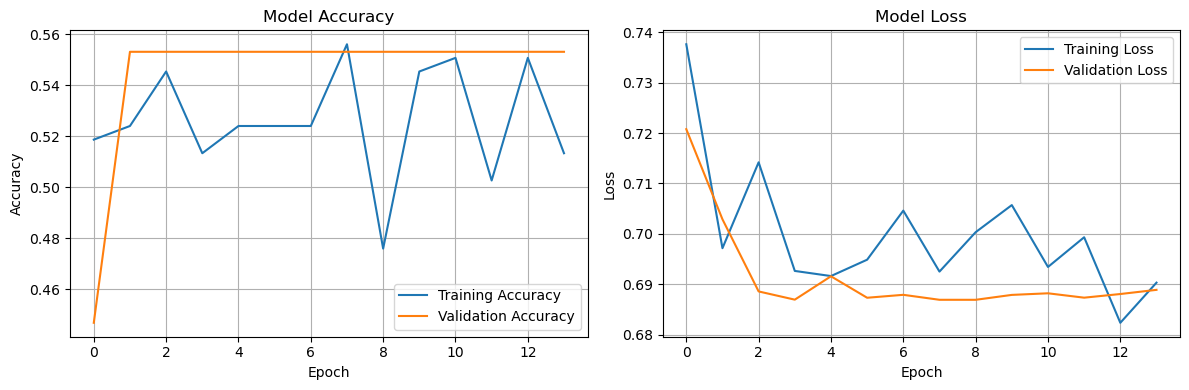

In [40]:
# ÌïôÏäµ Í≤∞Í≥º ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 4))

# Ï†ïÌôïÎèÑ Í∑∏ÎûòÌîÑ
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# ÏÜêÏã§ Í∑∏ÎûòÌîÑ
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [59]:
import numpy as np
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

print("=== Î™®Îç∏ ÏßÑÎã® ÏãúÏûë ===")

# 1. Î™®Îç∏Ïù¥ Ï†ïÏùòÎêòÏñ¥ ÏûàÎäîÏßÄ ÌôïÏù∏
if 'model' not in locals():
    print("‚ùå Î™®Îç∏Ïù¥ Ï†ïÏùòÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§. Î®ºÏ†Ä Î™®Îç∏ÏùÑ ÏÉùÏÑ±ÌïòÍ≥† ÌïôÏäµÏãúÌÇ§ÏÑ∏Ïöî.")
else:
    print("‚úÖ Î™®Îç∏ Î∞úÍ≤¨")

# 2. EfficientNetB0 Î∞±Î≥∏ Ï∂úÎ†• ÌôïÏù∏
print("\n=== Î∞±Î≥∏ Ï∂úÎ†• Î∂ÑÏÑù ===")
test_input = np.random.random((1, 224, 224, 3)).astype('float32')

# Î∞±Î≥∏ÎßåÏùò Ï∂úÎ†• ÌôïÏù∏
if 'base_model' in locals():
    backbone_output = base_model.predict(test_input, verbose=0)
    print(f"Î∞±Î≥∏ Ï∂úÎ†• shape: {backbone_output.shape}")
    print(f"Î∞±Î≥∏ Ï∂úÎ†• ÌÜµÍ≥Ñ - ÌèâÍ∑†: {backbone_output.mean():.6f}, ÌëúÏ§ÄÌé∏Ï∞®: {backbone_output.std():.6f}")
    
    if backbone_output.std() > 0.1:
        print("‚úÖ Î∞±Î≥∏Ïù¥ ÏùòÎØ∏ÏûàÎäî ÌäπÏßïÏùÑ Ï∂îÏ∂úÌïòÍ≥† ÏûàÏùå")
    else:
        print("‚ö†Ô∏è Î∞±Î≥∏ Ï∂úÎ†•Ïùò Îã§ÏñëÏÑ±Ïù¥ ÎÇÆÏùå")
else:
    print("base_model Î≥ÄÏàòÎ•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")

# 3. Í∞Å Ï∏µÎ≥Ñ Ï∂úÎ†• ÌôïÏù∏
print("\n=== Ìó§Îìú Ï∏µÎ≥Ñ Î∂ÑÏÑù ===")

try:
    # Î™®Îç∏ Ï∏µ Íµ¨Ï°∞ ÌôïÏù∏
    pooling_layer_idx = None
    dense_128_layer_idx = None
    final_dense_idx = None
    
    for i, layer in enumerate(model.layers):
        layer_type = type(layer).__name__
        print(f"Layer {i}: {layer.name} - {layer_type}")
        
        if 'global_average_pooling2d' in layer.name.lower():
            pooling_layer_idx = i
        elif layer_type == 'Dense':
            if hasattr(layer, 'units'):
                if layer.units == 128:
                    dense_128_layer_idx = i
                elif layer.units == 1:
                    final_dense_idx = i
    
    print(f"\nÎ∞úÍ≤¨Îêú Ï£ºÏöî Ï∏µ:")
    print(f"GlobalAveragePooling2D: Layer {pooling_layer_idx}")
    print(f"Dense(128): Layer {dense_128_layer_idx}")
    print(f"Dense(1): Layer {final_dense_idx}")
    
    # ÌäπÏßïÎ≤°ÌÑ∞ Ï∂îÏ∂ú (GlobalAveragePooling2D Ï∂úÎ†•)
    if pooling_layer_idx is not None:
        feature_extractor = Model(inputs=model.input, outputs=model.layers[pooling_layer_idx].output)
        features = feature_extractor.predict(test_input, verbose=0)
        print(f"\nüìä ÌäπÏßïÎ≤°ÌÑ∞ (1280Ï∞®Ïõê): {features.shape}")
        print(f"   ÌèâÍ∑†: {features.mean():.6f}, ÌëúÏ§ÄÌé∏Ï∞®: {features.std():.6f}")
        
        if features.std() < 0.01:
            print("‚ö†Ô∏è ÌäπÏßïÎ≤°ÌÑ∞ ÌëúÏ§ÄÌé∏Ï∞®Í∞Ä ÎÑàÎ¨¥ ÎÇÆÏùå")
        else:
            print("‚úÖ ÌäπÏßïÎ≤°ÌÑ∞Í∞Ä Îã§ÏñëÏÑ±ÏùÑ Í∞ÄÏßê")
    
    # Dense(128) Ï∂úÎ†• ÌôïÏù∏
    if dense_128_layer_idx is not None:
        dense_extractor = Model(inputs=model.input, outputs=model.layers[dense_128_layer_idx].output)
        dense_output = dense_extractor.predict(test_input, verbose=0)
        print(f"\nüìä Dense(128) Ï∂úÎ†•: {dense_output.shape}")
        print(f"   ÌèâÍ∑†: {dense_output.mean():.6f}, ÌëúÏ§ÄÌé∏Ï∞®: {dense_output.std():.6f}")
        
        if dense_output.std() < 0.01:
            print("‚ö†Ô∏è Dense(128) Ï∂úÎ†•Ïù¥ Í±∞Ïùò ÎèôÏùº - Í∞ÄÏ§ëÏπò Î¨∏Ï†ú Í∞ÄÎä•")
        else:
            print("‚úÖ Dense(128)Ïù¥ ÏùòÎØ∏ÏûàÎäî Î≥ÄÌôò ÏàòÌñâ")
        
        # Dense(128) Í∞ÄÏ§ëÏπò ÌôïÏù∏
        dense_layer = model.layers[dense_128_layer_idx]
        weights, bias = dense_layer.get_weights()
        print(f"   Í∞ÄÏ§ëÏπò ÌÜµÍ≥Ñ - ÌèâÍ∑†: {weights.mean():.6f}, ÌëúÏ§ÄÌé∏Ï∞®: {weights.std():.6f}")
        print(f"   Ìé∏Ìñ• ÌÜµÍ≥Ñ - ÌèâÍ∑†: {bias.mean():.6f}")
    
    # ÏµúÏ¢Ö Dense(1) Í∞ÄÏ§ëÏπò ÌôïÏù∏
    if final_dense_idx is not None:
        final_layer = model.layers[final_dense_idx]
        final_weights, final_bias = final_layer.get_weights()
        print(f"\nüìä ÏµúÏ¢Ö Dense(1) Í∞ÄÏ§ëÏπò:")
        print(f"   Í∞ÄÏ§ëÏπò ÌÜµÍ≥Ñ - ÌèâÍ∑†: {final_weights.mean():.6f}, ÌëúÏ§ÄÌé∏Ï∞®: {final_weights.std():.6f}")
        print(f"   Ìé∏Ìñ•: {final_bias[0]:.6f}")
        
        if abs(final_weights.mean()) < 0.001 and final_weights.std() < 0.001:
            print("üö® ÏµúÏ¢Ö Î†àÏù¥Ïñ¥ Í∞ÄÏ§ëÏπòÍ∞Ä Í±∞Ïùò 0 ‚Üí sigmoid(0) ‚âà 0.5 Í≥†Ï†ï!")
    
    # ÏµúÏ¢Ö ÏòàÏ∏° ÌôïÏù∏
    final_pred = model.predict(test_input, verbose=0)
    print(f"\nüìä ÏµúÏ¢Ö ÏòàÏ∏°: {final_pred[0][0]:.6f}")
    
    # Ïó¨Îü¨ ÎûúÎç§ ÏûÖÎ†•Ïóê ÎåÄÌïú ÏòàÏ∏° ÌôïÏù∏
    print("\n=== Îã§ÏñëÌïú ÏûÖÎ†•Ïóê ÎåÄÌïú ÏòàÏ∏° ÌôïÏù∏ ===")
    predictions = []
    for i in range(5):
        random_input = np.random.random((1, 224, 224, 3)).astype('float32')
        pred = model.predict(random_input, verbose=0)[0][0]
        predictions.append(pred)
        print(f"ÎûúÎç§ ÏûÖÎ†• {i+1}: {pred:.6f}")
    
    pred_std = np.std(predictions)
    print(f"\nÏòàÏ∏° ÌëúÏ§ÄÌé∏Ï∞®: {pred_std:.6f}")
    
    if pred_std < 0.01:
        print("üö® Î™®Îì† ÏòàÏ∏°Ïù¥ Í±∞Ïùò ÎèôÏùº - Î™®Îç∏Ïù¥ ÏûÖÎ†•ÏùÑ Íµ¨Î∂ÑÌïòÏßÄ Î™ªÌï®")
        print("\nÍ∞ÄÎä•Ìïú ÏõêÏù∏:")
        print("1. ÏµúÏ¢Ö Dense Î†àÏù¥Ïñ¥ Í∞ÄÏ§ëÏπòÍ∞Ä 0Ïóê Í∞ÄÍπåÏõÄ")
        print("2. ÌïôÏäµÏù¥ Ï†ÑÌòÄ ÏßÑÌñâÎêòÏßÄ ÏïäÏùå")
        print("3. ÌïôÏäµÎ•†Ïù¥ ÎÑàÎ¨¥ ÎÇÆÏùå")
        print("4. Îç∞Ïù¥ÌÑ∞Í∞Ä ÎÑàÎ¨¥ Ï†ÅÏñ¥ÏÑú Ìå®ÌÑ¥ÏùÑ ÌïôÏäµÌïòÏßÄ Î™ªÌï®")
    else:
        print("‚úÖ ÏûÖÎ†•Ïóê Îî∞Îùº Îã§Î•∏ ÏòàÏ∏°ÏùÑ Ìï®")

except Exception as e:
    print(f"‚ùå ÏßÑÎã® Ï§ë Ïò§Î•ò Î∞úÏÉù: {str(e)}")
    import traceback
    traceback.print_exc()

print("\n=== ÏßÑÎã® ÏôÑÎ£å ===")

=== Î™®Îç∏ ÏßÑÎã® ÏãúÏûë ===
‚úÖ Î™®Îç∏ Î∞úÍ≤¨

=== Î∞±Î≥∏ Ï∂úÎ†• Î∂ÑÏÑù ===
Î∞±Î≥∏ Ï∂úÎ†• shape: (1, 7, 7, 1280)
Î∞±Î≥∏ Ï∂úÎ†• ÌÜµÍ≥Ñ - ÌèâÍ∑†: -0.102654, ÌëúÏ§ÄÌé∏Ï∞®: 0.468709
‚úÖ Î∞±Î≥∏Ïù¥ ÏùòÎØ∏ÏûàÎäî ÌäπÏßïÏùÑ Ï∂îÏ∂úÌïòÍ≥† ÏûàÏùå

=== Ìó§Îìú Ï∏µÎ≥Ñ Î∂ÑÏÑù ===
Layer 0: input_layer_4 - InputLayer
Layer 1: rescaling_8 - Rescaling
Layer 2: normalization_4 - Normalization
Layer 3: rescaling_9 - Rescaling
Layer 4: stem_conv_pad - ZeroPadding2D
Layer 5: stem_conv - Conv2D
Layer 6: stem_bn - BatchNormalization
Layer 7: stem_activation - Activation
Layer 8: block1a_dwconv - DepthwiseConv2D
Layer 9: block1a_bn - BatchNormalization
Layer 10: block1a_activation - Activation
Layer 11: block1a_se_squeeze - GlobalAveragePooling2D
Layer 12: block1a_se_reshape - Reshape
Layer 13: block1a_se_reduce - Conv2D
Layer 14: block1a_se_expand - Conv2D
Layer 15: block1a_se_excite - Multiply
Layer 16: block1a_project_conv - Conv2D
Layer 17: block1a_project_bn - BatchNormalization
Layer 18: block2a_expand_co

In [41]:
# ÏÑ±Îä• ÌèâÍ∞Ä
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Í≤ÄÏ¶ù Ï†ïÌôïÎèÑ: {val_accuracy:.4f}")
print(f"Í≤ÄÏ¶ù ÏÜêÏã§: {val_loss:.4f}")

# ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÏÑù
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

from sklearn.metrics import classification_report, confusion_matrix
print("\nÎ∂ÑÎ•ò Î≥¥Í≥†ÏÑú:")
print(classification_report(y_val, y_pred, target_names=classes))

print("\nÌòºÎèô ÌñâÎ†¨:")
print(confusion_matrix(y_val, y_pred))

Í≤ÄÏ¶ù Ï†ïÌôïÎèÑ: 0.5532
Í≤ÄÏ¶ù ÏÜêÏã§: 0.6869
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 915ms/step

Î∂ÑÎ•ò Î≥¥Í≥†ÏÑú:
              precision    recall  f1-score   support

 non_teasing       0.55      1.00      0.71        26
     teasing       0.00      0.00      0.00        21

    accuracy                           0.55        47
   macro avg       0.28      0.50      0.36        47
weighted avg       0.31      0.55      0.39        47


ÌòºÎèô ÌñâÎ†¨:
[[26  0]
 [21  0]]


c:\Users\pjjeo\anaconda3\envs\pytorch-cuda124\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pjjeo\anaconda3\envs\pytorch-cuda124\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pjjeo\anaconda3\envs\pytorch-cuda124\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [15]:
# ÏµúÏ¢Ö Î™®Îç∏ Ï†ÄÏû•
model.save('teasing_classifier_final.h5')
print("Î™®Îç∏Ïù¥ Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§: teasing_classifier_final.h5")

Î™®Îç∏Ïù¥ Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§: teasing_classifier_final.h5


In [25]:
def predict_teasing(img_path, model_path='teasing_classifier_final.h5'):
    """Îã®Ïùº Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌï¥ ÏïΩÏò¨Î¶¨Í∏∞ Ïó¨Î∂Ä ÏòàÏ∏°"""
    from tensorflow.keras.models import load_model
    
    # Î™®Îç∏ Î°úÎìú
    model = load_model(model_path)
    
    # Ïù¥ÎØ∏ÏßÄ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
    img = cv2.imread(img_path)
    if img is None:
        return None, "Ïù¥ÎØ∏ÏßÄÎ•º ÏùΩÏùÑ Ïàò ÏóÜÏäµÎãàÎã§."
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    
    # ÏòàÏ∏°
    pred_prob = model.predict(img)[0][0]
    pred_class = "ÏïΩÏò¨Î¶¨Í∏∞" if pred_prob > 0.5 else "ÎπÑÏïΩÏò¨Î¶¨Í∏∞"
    
    return pred_prob, pred_class

# ÏÇ¨Ïö© ÏòàÏãú (Ïã§Ï†ú Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°úÎ°ú Î≥ÄÍ≤ΩÌïòÏÑ∏Ïöî)
prob, class_name = predict_teasing(r"D:\my_projects\calmman-facial-classification\data\processed\non_teasing\1212.png")
print(f"ÏòàÏ∏° ÌôïÎ•†: {prob:.4f}, ÏòàÏ∏° ÌÅ¥ÎûòÏä§: {class_name}")

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 707ms/step
ÏòàÏ∏° ÌôïÎ•†: 0.8901, ÏòàÏ∏° ÌÅ¥ÎûòÏä§: ÏïΩÏò¨Î¶¨Í∏∞


In [44]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Windows ÌôòÍ≤ΩÏóêÏÑú ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'Malgun Gothic'  # ÎßëÏùÄ Í≥†Îîï
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

print("ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï ÏôÑÎ£å (ÎßëÏùÄ Í≥†Îîï)")

ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï ÏôÑÎ£å (ÎßëÏùÄ Í≥†Îîï)


Ï¥ù 8Í∞úÏùò ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄÎ•º Î∞úÍ≤¨ÌñàÏäµÎãàÎã§.
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 90ms/step

=== Î∂ÑÎ•ò Í≤∞Í≥º ÏöîÏïΩ ===
ÏïΩÏò¨Î¶¨Í∏∞: 0Í∞ú
ÎπÑÏïΩÏò¨Î¶¨Í∏∞: 8Í∞ú
ÎπÑÏú® - ÏïΩÏò¨Î¶¨Í∏∞:0 vs ÎπÑÏïΩÏò¨Î¶¨Í∏∞:8


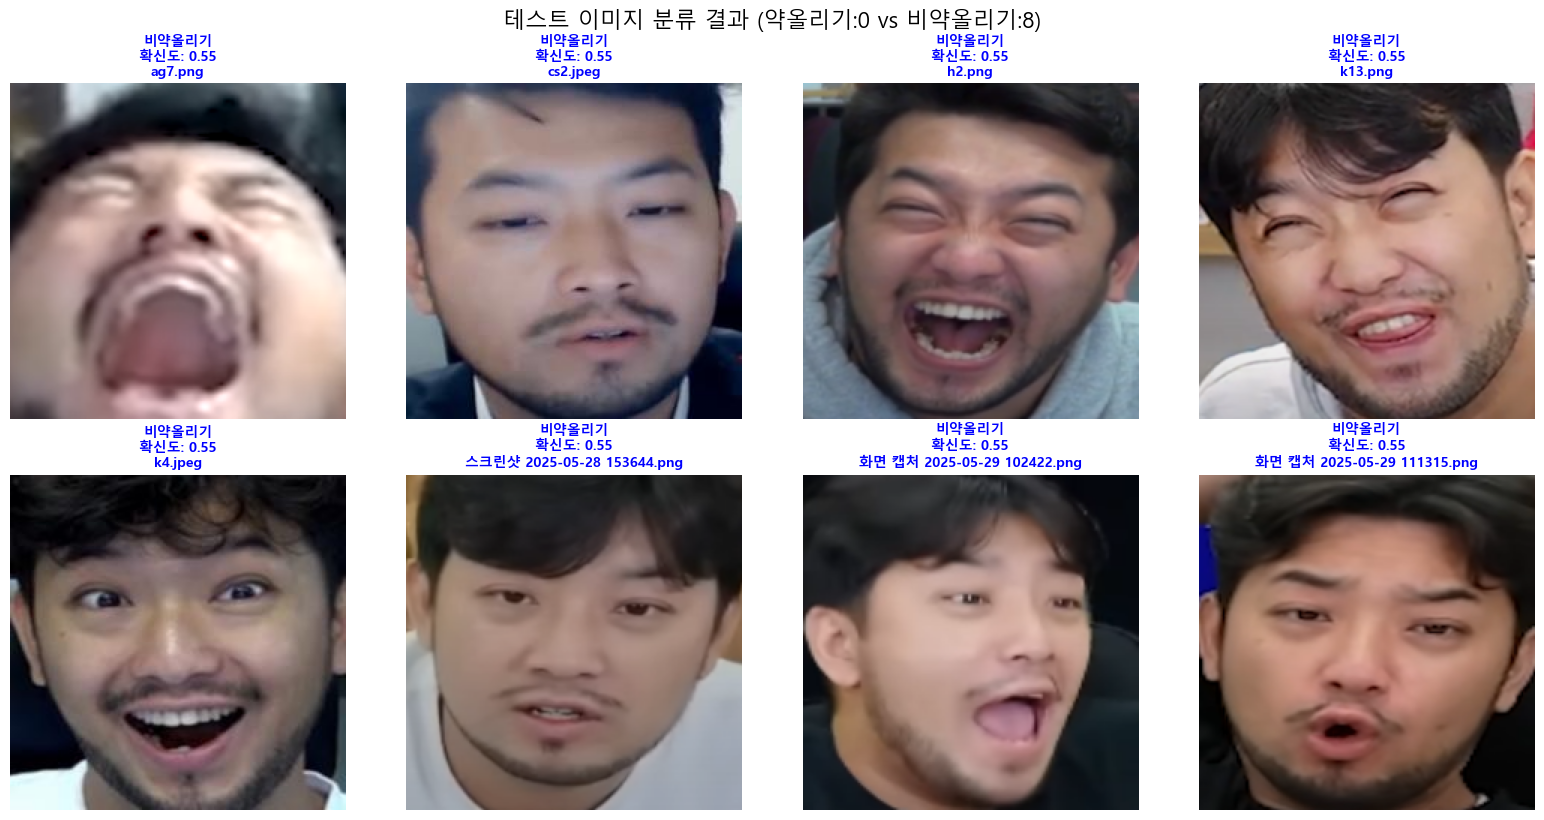

In [46]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

def test_images_visualization(test_dir, model, img_size=224):
    """ÌÖåÏä§Ìä∏ ÎîîÎ†âÌÜ†Î¶¨Ïùò Î™®Îì† Ïù¥ÎØ∏ÏßÄÎ•º Î∂ÑÎ•òÌïòÍ≥† ÏãúÍ∞ÅÌôî"""
    
    # Ïù¥ÎØ∏ÏßÄ ÌååÏùº Î™©Î°ù Í∞ÄÏ†∏Ïò§Í∏∞
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    image_files = [f for f in os.listdir(test_dir) 
                   if f.lower().endswith(image_extensions)]
    
    if not image_files:
        print("ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏóÜÏäµÎãàÎã§!")
        return
    
    print(f"Ï¥ù {len(image_files)}Í∞úÏùò ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄÎ•º Î∞úÍ≤¨ÌñàÏäµÎãàÎã§.")
    
    # Ïù¥ÎØ∏ÏßÄ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
    images = []
    filenames = []
    
    for filename in image_files:
        img_path = os.path.join(test_dir, filename)
        
        try:
            # Ïù¥ÎØ∏ÏßÄ Î°úÎìú
            img = cv2.imread(img_path)
            if img is None:
                # PILÎ°ú Ïû¨ÏãúÎèÑ
                pil_img = Image.open(img_path)
                img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
            
            # BGR to RGB Î≥ÄÌôò
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # ÌÅ¨Í∏∞ Ï°∞Ï†ï Î∞è Ï†ïÍ∑úÌôî
            img_resized = cv2.resize(img_rgb, (img_size, img_size))
            img_normalized = img_resized.astype('float32') / 255.0
            
            images.append(img_normalized)
            filenames.append(filename)
            
        except Exception as e:
            print(f"Ïù¥ÎØ∏ÏßÄ Î°úÎìú Ïã§Ìå® - {filename}: {str(e)}")
            continue
    
    if not images:
        print("Î°úÎìú Í∞ÄÎä•Ìïú Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏóÜÏäµÎãàÎã§!")
        return
    
    # Î∞∞ÏπòÎ°ú ÏòàÏ∏°
    images_array = np.array(images)
    predictions = model.predict(images_array)
    
    # Í≤∞Í≥º Î∂ÑÏÑù
    teasing_count = 0
    non_teasing_count = 0
    results = []
    
    for i, (pred_prob, filename) in enumerate(zip(predictions, filenames)):
        prob = pred_prob[0]
        pred_class = "ÏïΩÏò¨Î¶¨Í∏∞" if prob > 0.5 else "ÎπÑÏïΩÏò¨Î¶¨Í∏∞"
        confidence = prob if prob > 0.5 else 1 - prob
        
        if pred_class == "ÏïΩÏò¨Î¶¨Í∏∞":
            teasing_count += 1
        else:
            non_teasing_count += 1
        
        results.append({
            'image': images[i],
            'filename': filename,
            'prediction': pred_class,
            'probability': prob,
            'confidence': confidence
        })
    
    # Í≤∞Í≥º ÏöîÏïΩ Ï∂úÎ†•
    print(f"\n=== Î∂ÑÎ•ò Í≤∞Í≥º ÏöîÏïΩ ===")
    print(f"ÏïΩÏò¨Î¶¨Í∏∞: {teasing_count}Í∞ú")
    print(f"ÎπÑÏïΩÏò¨Î¶¨Í∏∞: {non_teasing_count}Í∞ú")
    print(f"ÎπÑÏú® - ÏïΩÏò¨Î¶¨Í∏∞:{teasing_count} vs ÎπÑÏïΩÏò¨Î¶¨Í∏∞:{non_teasing_count}")
    
    # ÏãúÍ∞ÅÌôî
    n_images = len(results)
    cols = 4  # Ìïú ÌñâÏóê 4Í∞úÏî©
    rows = math.ceil(n_images / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    
    # axesÍ∞Ä 1Ï∞®ÏõêÏù∏ Í≤ΩÏö∞ 2Ï∞®ÏõêÏúºÎ°ú Î≥ÄÌôò
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i, result in enumerate(results):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        
        # Ïù¥ÎØ∏ÏßÄ ÌëúÏãú
        ax.imshow(result['image'])
        
        # Ï†úÎ™© ÏÑ§Ï†ï (ÏòàÏ∏° Í≤∞Í≥º + ÌôïÏã†ÎèÑ)
        color = 'red' if result['prediction'] == 'ÏïΩÏò¨Î¶¨Í∏∞' else 'blue'
        title = f"{result['prediction']}\nÌôïÏã†ÎèÑ: {result['confidence']:.2f}\n{result['filename']}"
        ax.set_title(title, fontsize=10, color=color, weight='bold')
        ax.axis('off')
    
    # Îπà ÏÑúÎ∏åÌîåÎ°Ø Ïà®Í∏∞Í∏∞
    for i in range(n_images, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ Î∂ÑÎ•ò Í≤∞Í≥º (ÏïΩÏò¨Î¶¨Í∏∞:{teasing_count} vs ÎπÑÏïΩÏò¨Î¶¨Í∏∞:{non_teasing_count})', 
                 fontsize=16, y=1.02)
    plt.show()
    
    return results

# Ïã§Ìñâ
test_dir = r'D:\my_projects\calmman-facial-classification\data\processed\test_image'
results = test_images_visualization(test_dir, model)

=== Î™®Îç∏ ÏßÑÎã® ÏãúÏûë ===
‚úÖ Î™®Îç∏ Î∞úÍ≤¨

=== Î∞±Î≥∏ Ï∂úÎ†• Î∂ÑÏÑù ===
Î∞±Î≥∏ Ï∂úÎ†• shape: (1, 7, 7, 1280)
Î∞±Î≥∏ Ï∂úÎ†• ÌÜµÍ≥Ñ - ÌèâÍ∑†: -0.102642, ÌëúÏ§ÄÌé∏Ï∞®: 0.468796

=== Ìó§Îìú Ï∏µÎ≥Ñ Î∂ÑÏÑù ===
Layer 0: input_layer_2 - InputLayer
‚ùå ÏßÑÎã® Ï§ë Ïò§Î•ò Î∞úÏÉù: name 'tf' is not defined

=== ÏßÑÎã® ÏôÑÎ£å ===


In [60]:
import numpy as np

print("=== 1Îã®Í≥Ñ: Í∞ÄÏ§ëÏπò Í∞ïÏ†ú Ï¥àÍ∏∞Ìôî ===")

# ÏµúÏ¢Ö Dense Î†àÏù¥Ïñ¥ Ï∞æÍ∏∞
final_dense_layer = None
for layer in reversed(model.layers):
    if hasattr(layer, 'units') and layer.units == 1:
        final_dense_layer = layer
        break

if final_dense_layer:
    # ÌòÑÏû¨ Í∞ÄÏ§ëÏπò ÌôïÏù∏
    old_weights, old_bias = final_dense_layer.get_weights()
    print(f"üîç Í∏∞Ï°¥ Í∞ÄÏ§ëÏπò:")
    print(f"   ÌèâÍ∑†: {old_weights.mean():.8f}")
    print(f"   ÌëúÏ§ÄÌé∏Ï∞®: {old_weights.std():.8f}")
    print(f"   Ìé∏Ìñ•: {old_bias[0]:.8f}")
    
    # ÏùòÎØ∏ÏûàÎäî ÌÅ¨Í∏∞Ïùò ÏÉà Í∞ÄÏ§ëÏπò ÏÉùÏÑ±
    new_weights = np.random.normal(0, 0.5, old_weights.shape)  # ÌëúÏ§ÄÌé∏Ï∞® 0.5
    new_bias = np.array([0.0])
    
    # Í∞ÄÏ§ëÏπò ÍµêÏ≤¥
    final_dense_layer.set_weights([new_weights, new_bias])
    
    # Í≤∞Í≥º ÌôïÏù∏
    updated_weights, updated_bias = final_dense_layer.get_weights()
    print(f"‚úÖ ÏÉà Í∞ÄÏ§ëÏπò:")
    print(f"   ÌèâÍ∑†: {updated_weights.mean():.6f}")
    print(f"   ÌëúÏ§ÄÌé∏Ï∞®: {updated_weights.std():.6f}")
    print(f"   Ìé∏Ìñ•: {updated_bias[0]:.6f}")
    
    # Ï¶âÏãú ÏòàÏ∏° ÌÖåÏä§Ìä∏
    test_predictions = []
    for i in range(3):
        test_input = np.random.random((1, 224, 224, 3))
        pred = model.predict(test_input, verbose=0)[0][0]
        test_predictions.append(pred)
        print(f"   ÌÖåÏä§Ìä∏ ÏòàÏ∏° {i+1}: {pred:.6f}")
    
    pred_std = np.std(test_predictions)
    print(f"   ÏòàÏ∏° Îã§ÏñëÏÑ± (ÌëúÏ§ÄÌé∏Ï∞®): {pred_std:.6f}")
    
    if pred_std > 0.01:
        print("üéâ Í∞ÄÏ§ëÏπò Ï¥àÍ∏∞Ìôî ÏÑ±Í≥µ! Ïù¥Ï†ú Îã§ÏñëÌïú ÏòàÏ∏°Í∞íÏù¥ ÎÇòÏòµÎãàÎã§.")
    else:
        print("‚ö†Ô∏è Ïó¨Ï†ÑÌûà ÏòàÏ∏°Ïù¥ Í≥†Ï†ïÎêòÏñ¥ ÏûàÏäµÎãàÎã§.")
        
else:
    print("‚ùå ÏµúÏ¢Ö Dense Î†àÏù¥Ïñ¥Î•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")

=== 1Îã®Í≥Ñ: Í∞ÄÏ§ëÏπò Í∞ïÏ†ú Ï¥àÍ∏∞Ìôî ===
üîç Í∏∞Ï°¥ Í∞ÄÏ§ëÏπò:
   ÌèâÍ∑†: 0.00013704
   ÌëúÏ§ÄÌé∏Ï∞®: 0.11838014
   Ìé∏Ìñ•: -0.00073585
‚úÖ ÏÉà Í∞ÄÏ§ëÏπò:
   ÌèâÍ∑†: -0.067422
   ÌëúÏ§ÄÌé∏Ï∞®: 0.545385
   Ìé∏Ìñ•: 0.000000
   ÌÖåÏä§Ìä∏ ÏòàÏ∏° 1: 0.341147
   ÌÖåÏä§Ìä∏ ÏòàÏ∏° 2: 0.340881
   ÌÖåÏä§Ìä∏ ÏòàÏ∏° 3: 0.340915
   ÏòàÏ∏° Îã§ÏñëÏÑ± (ÌëúÏ§ÄÌé∏Ï∞®): 0.000118
‚ö†Ô∏è Ïó¨Ï†ÑÌûà ÏòàÏ∏°Ïù¥ Í≥†Ï†ïÎêòÏñ¥ ÏûàÏäµÎãàÎã§.


In [61]:
from tensorflow.keras.optimizers import Adam

print("\n=== 2Îã®Í≥Ñ: ÌïôÏäµÎ•† ÎåÄÌè≠ Ï¶ùÍ∞Ä ===")

# ÌòÑÏû¨ ÌïôÏäµÎ•† ÌôïÏù∏
current_lr = model.optimizer.learning_rate.numpy()
print(f"üîç ÌòÑÏû¨ ÌïôÏäµÎ•†: {current_lr:.8f}")

# ÌïôÏäµÎ•† 10Î∞∞ Ï¶ùÍ∞Ä
new_lr = 0.01  # Í∏∞Î≥∏ 0.001ÏóêÏÑú 10Î∞∞
print(f"‚úÖ ÏÉà ÌïôÏäµÎ•†: {new_lr}")

# Ïû¨Ïª¥ÌååÏùº
model.compile(
    optimizer=Adam(learning_rate=new_lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("‚úÖ ÎÜíÏùÄ ÌïôÏäµÎ•†Î°ú Ïû¨Ïª¥ÌååÏùº ÏôÑÎ£å")


=== 2Îã®Í≥Ñ: ÌïôÏäµÎ•† ÎåÄÌè≠ Ï¶ùÍ∞Ä ===
üîç ÌòÑÏû¨ ÌïôÏäµÎ•†: 0.00100000
‚úÖ ÏÉà ÌïôÏäµÎ•†: 0.01
‚úÖ ÎÜíÏùÄ ÌïôÏäµÎ•†Î°ú Ïû¨Ïª¥ÌååÏùº ÏôÑÎ£å


In [62]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

print("\n=== 3Îã®Í≥Ñ: ÏãúÎèô Í±∏Í∏∞ ÌïôÏäµ ===")

# ÏûëÏùÄ Î∞∞ÏπòÎ°ú Îπ†Î•∏ ÌïôÏäµ
print("üöÄ ÏãúÎèô Í±∏Í∏∞ ÌïôÏäµ ÏãúÏûë...")

# ÏΩúÎ∞± ÏÑ§Ï†ï (Í≥ºÏ†ÅÌï© Î∞©ÏßÄ)
quick_callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

# ÏßßÍ≥† Í∞ïÎ†•Ìïú ÌïôÏäµ
history_kickstart = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # ÏßßÍ≤å
    batch_size=8,  # ÏûëÏùÄ Î∞∞ÏπòÎ°ú Îçî ÏûêÏ£º ÏóÖÎç∞Ïù¥Ìä∏
    callbacks=quick_callbacks,
    verbose=1
)

print("‚úÖ ÏãúÎèô Í±∏Í∏∞ ÌïôÏäµ ÏôÑÎ£å!")


=== 3Îã®Í≥Ñ: ÏãúÎèô Í±∏Í∏∞ ÌïôÏäµ ===
üöÄ ÏãúÎèô Í±∏Í∏∞ ÌïôÏäµ ÏãúÏûë...
Epoch 1/10
23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 149ms/step - accuracy: 0.4425 - loss: 2.4037 - val_accuracy: 0.4444 - val_loss: 0.6944
Epoch 2/10
23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 91ms/step - accuracy: 0.4965 - loss: 0.7053 - val_accuracy: 0.5556 - val_loss: 0.6876
Epoch 3/10
23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 93ms/step - accuracy: 0.5770 - loss: 0.6873 - val_accuracy: 0.5556 - val_loss: 0.6872
Epoch 4/10
23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 92ms/step - accuracy: 0.5412 - loss: 0.6878 - val_accuracy: 0.5556 - val_loss: 0.6870
Epoch 5/10
23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 90ms/step - accuracy: 0.5361 - loss: 0.6914 - val_accuracy: 0.5556 - val_loss: 0.6871
Epoch 6/10
23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 93ms/ste


=== 4Îã®Í≥Ñ: ÏãúÎèô ÏÉÅÌÉú ÌôïÏù∏ ===


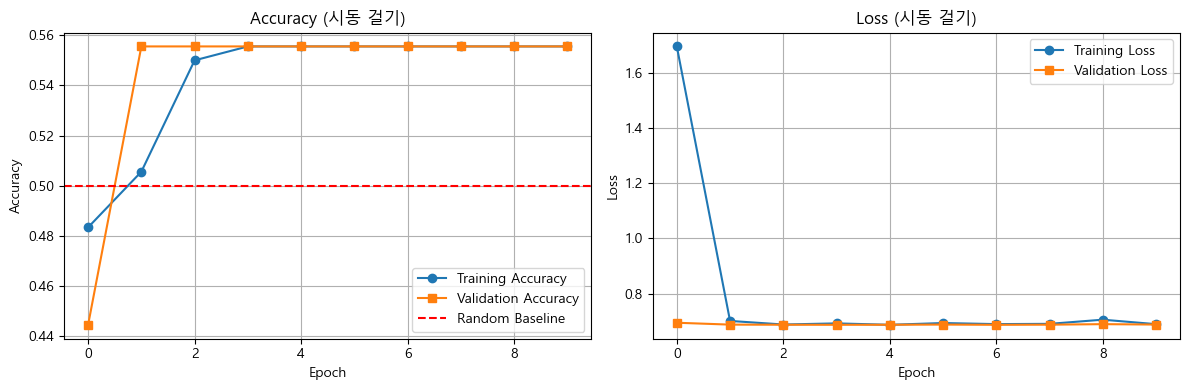

üéØ ÏãúÎèô ÌõÑ Í≤ÄÏ¶ù Ï†ïÌôïÎèÑ: 0.5556
üéØ ÏãúÎèô ÌõÑ Í≤ÄÏ¶ù ÏÜêÏã§: 0.6869
üéØ ÏòàÏ∏° ÌôïÎ•† Î≤îÏúÑ: 0.4490 ~ 0.4491
üéØ ÏòàÏ∏° ÌôïÎ•† ÌëúÏ§ÄÌé∏Ï∞®: 0.0000
‚ö†Ô∏è ÏãúÎèôÏù¥ ÏôÑÏ†ÑÌûà Í±∏Î¶¨ÏßÄ ÏïäÏïòÏäµÎãàÎã§. Ï∂îÍ∞Ä Ï°∞ÏπòÍ∞Ä ÌïÑÏöîÌï©ÎãàÎã§.


In [63]:
print("\n=== 4Îã®Í≥Ñ: ÏãúÎèô ÏÉÅÌÉú ÌôïÏù∏ ===")

# ÌïôÏäµ Í≥ºÏ†ï ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_kickstart.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_kickstart.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.axhline(y=0.5, color='r', linestyle='--', label='Random Baseline')
plt.title('Accuracy (ÏãúÎèô Í±∏Í∏∞)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_kickstart.history['loss'], label='Training Loss', marker='o')
plt.plot(history_kickstart.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Loss (ÏãúÎèô Í±∏Í∏∞)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ÏÑ±Îä• ÌôïÏù∏
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"üéØ ÏãúÎèô ÌõÑ Í≤ÄÏ¶ù Ï†ïÌôïÎèÑ: {val_accuracy:.4f}")
print(f"üéØ ÏãúÎèô ÌõÑ Í≤ÄÏ¶ù ÏÜêÏã§: {val_loss:.4f}")

# ÏòàÏ∏° Îã§ÏñëÏÑ± Ïû¨ÌôïÏù∏
y_pred_prob_new = model.predict(X_val, verbose=0)
print(f"üéØ ÏòàÏ∏° ÌôïÎ•† Î≤îÏúÑ: {y_pred_prob_new.min():.4f} ~ {y_pred_prob_new.max():.4f}")
print(f"üéØ ÏòàÏ∏° ÌôïÎ•† ÌëúÏ§ÄÌé∏Ï∞®: {y_pred_prob_new.std():.4f}")

if y_pred_prob_new.std() > 0.05:
    print("üéâ ÏãúÎèô ÏÑ±Í≥µ! Î™®Îç∏Ïù¥ Îã§ÏñëÌïú ÏòàÏ∏°ÏùÑ Ìï©ÎãàÎã§.")
    
    # Î∂ÑÎ•ò Î≥¥Í≥†ÏÑú
    y_pred_new = (y_pred_prob_new > 0.5).astype(int).flatten()
    from sklearn.metrics import classification_report
    print("\nüìä ÏãúÎèô ÌõÑ Î∂ÑÎ•ò ÏÑ±Îä•:")
    print(classification_report(y_val, y_pred_new, target_names=['non_teasing', 'teasing']))
else:
    print("‚ö†Ô∏è ÏãúÎèôÏù¥ ÏôÑÏ†ÑÌûà Í±∏Î¶¨ÏßÄ ÏïäÏïòÏäµÎãàÎã§. Ï∂îÍ∞Ä Ï°∞ÏπòÍ∞Ä ÌïÑÏöîÌï©ÎãàÎã§.")

In [65]:
print("=== 5Îã®Í≥Ñ: Í∑πÎã®Ï†Å ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Ï†ÅÏö© ===")

# ÌòÑÏû¨ ÏÉÅÌÉúÍ∞Ä Ïó¨Ï†ÑÌûà Í≥†Ï†ïÎêòÏñ¥ ÏûàÏúºÎØÄÎ°ú Í∞ïÎ†•Ìïú Ï°∞Ïπò ÌïÑÏöî
extreme_weights = {
    0: 1.0,    # ÎπÑÏïΩÏò¨Î¶¨Í∏∞
    1: 10.0    # ÏïΩÏò¨Î¶¨Í∏∞Ïóê 10Î∞∞ Í∞ÄÏ§ëÏπò (Îçî Í∞ïÌïòÍ≤å)
}

print("üî• Í∑πÎã®Ï†Å ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπòÎ°ú Ïû¨ÌïôÏäµ...")
print(f"ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò: {extreme_weights}")

# Îçî Í∏¥ ÌïôÏäµÏúºÎ°ú Î≥ÄÍ≤Ω
history_extreme = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Îçî Í∏∏Í≤å
    batch_size=4,   # Îçî ÏûëÏùÄ Î∞∞Ïπò (ÏÜåÏàò ÌÅ¥ÎûòÏä§Í∞Ä Ìè¨Ìï®Îê† ÌôïÎ•† Ï¶ùÍ∞Ä)
    class_weight=extreme_weights,
    verbose=1
)

# Ï¶âÏãú ÌôïÏù∏
val_loss_final, val_accuracy_final = model.evaluate(X_val, y_val, verbose=0)
y_pred_extreme = model.predict(X_val, verbose=0)

print(f"\nüéØ Í∑πÎã®Ï†Å Í∞ÄÏ§ëÏπò ÌõÑ Í≤∞Í≥º:")
print(f"   Í≤ÄÏ¶ù Ï†ïÌôïÎèÑ: {val_accuracy_final:.4f}")
print(f"   ÏòàÏ∏° Î≤îÏúÑ: {y_pred_extreme.min():.4f} ~ {y_pred_extreme.max():.4f}")
print(f"   ÏòàÏ∏° ÌëúÏ§ÄÌé∏Ï∞®: {y_pred_extreme.std():.4f}")

if y_pred_extreme.std() > 0.05:
    print("üéâ ÏôÑÏ†ÑÌïú ÏãúÎèô ÏÑ±Í≥µ!")
else:
    print("‚ö†Ô∏è Ï∂îÍ∞Ä Ï°∞Ïπò Í≤ÄÌÜ† ÌïÑÏöî")

=== 5Îã®Í≥Ñ: Í∑πÎã®Ï†Å ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Ï†ÅÏö© ===
üî• Í∑πÎã®Ï†Å ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπòÎ°ú Ïû¨ÌïôÏäµ...
ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò: {0: 1.0, 1: 10.0}
Epoch 1/20
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 25s 251ms/step - accuracy: 0.6521 - loss: 92.5285 - val_accuracy: 0.5556 - val_loss: 0.6886
Epoch 2/20
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 228ms/step - accuracy: 0.7604 - loss: 9.5477 - val_accuracy: 0.5556 - val_loss: 0.6881
Epoch 3/20
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 227ms/step - accuracy: 0.7951 - loss: 11.0609 - val_accuracy: 0.5556 - val_loss: 0.6917
Epoch 4/20
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 228ms/step - accuracy: 0.7095 - loss: 1.5339 - val_accuracy: 0.5556 - val_loss: 0.6997
Epoch 5/20
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 227ms/step - accuracy: 0.7643 - loss: 2.1661 - val_accuracy: 0.5556 - val_loss: 0.7086
Epoch 6/2

In [67]:
print("=== üéØ ÏôÑÏ†ÑÌïú ÏÑ±Îä• ÌèâÍ∞Ä ===")

# 1. ÏÉÅÏÑ∏ Î∂ÑÎ•ò Î≥¥Í≥†ÏÑú
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_prob_final = model.predict(X_val, verbose=0)
y_pred_final = (y_pred_prob_final > 0.5).astype(int).flatten()

print("üìä ÏµúÏ¢Ö Î∂ÑÎ•ò Î≥¥Í≥†ÏÑú:")
print(classification_report(y_val, y_pred_final, target_names=['non_teasing', 'teasing']))

print("\nüìä ÌòºÎèô ÌñâÎ†¨:")
cm = confusion_matrix(y_val, y_pred_final)
print(cm)

# 2. ÌÅ¥ÎûòÏä§Î≥Ñ ÏòàÏ∏° Î∂ÑÌè¨ ÌôïÏù∏
teasing_probs = y_pred_prob_final[y_val == 1].flatten()  # Ïã§Ï†ú ÏïΩÏò¨Î¶¨Í∏∞
non_teasing_probs = y_pred_prob_final[y_val == 0].flatten()  # Ïã§Ï†ú ÎπÑÏïΩÏò¨Î¶¨Í∏∞

print(f"\nüìà ÏòàÏ∏° ÌôïÎ•† Î∂ÑÌè¨:")
print(f"Ïã§Ï†ú ÏïΩÏò¨Î¶¨Í∏∞ ÌÅ¥ÎûòÏä§ ÏòàÏ∏° ÌèâÍ∑†: {teasing_probs.mean():.4f}")
print(f"Ïã§Ï†ú ÎπÑÏïΩÏò¨Î¶¨Í∏∞ ÌÅ¥ÎûòÏä§ ÏòàÏ∏° ÌèâÍ∑†: {non_teasing_probs.mean():.4f}")

# 3. ÏûÑÍ≥ÑÍ∞í ÏµúÏ†ÅÌôî
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_final)
roc_auc = auc(fpr, tpr)

print(f"\nüìä ROC AUC: {roc_auc:.4f}")

# ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í Ï∞æÍ∏∞ (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í: {optimal_threshold:.4f}")

# ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞íÏúºÎ°ú Ïû¨ÌèâÍ∞Ä
y_pred_optimal = (y_pred_prob_final > optimal_threshold).astype(int).flatten()
print(f"\nüìä ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í({optimal_threshold:.3f}) Ï†ÅÏö© Í≤∞Í≥º:")
print(classification_report(y_val, y_pred_optimal, target_names=['non_teasing', 'teasing']))

=== üéØ ÏôÑÏ†ÑÌïú ÏÑ±Îä• ÌèâÍ∞Ä ===
üìä ÏµúÏ¢Ö Î∂ÑÎ•ò Î≥¥Í≥†ÏÑú:
              precision    recall  f1-score   support

 non_teasing       0.00      0.00      0.00        25
     teasing       0.44      1.00      0.62        20

    accuracy                           0.44        45
   macro avg       0.22      0.50      0.31        45
weighted avg       0.20      0.44      0.27        45


üìä ÌòºÎèô ÌñâÎ†¨:
[[ 0 25]
 [ 0 20]]

üìà ÏòàÏ∏° ÌôïÎ•† Î∂ÑÌè¨:
Ïã§Ï†ú ÏïΩÏò¨Î¶¨Í∏∞ ÌÅ¥ÎûòÏä§ ÏòàÏ∏° ÌèâÍ∑†: 0.6535
Ïã§Ï†ú ÎπÑÏïΩÏò¨Î¶¨Í∏∞ ÌÅ¥ÎûòÏä§ ÏòàÏ∏° ÌèâÍ∑†: 0.7804

üìä ROC AUC: 0.2760
ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í: 0.9086

üìä ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í(0.909) Ï†ÅÏö© Í≤∞Í≥º:
              precision    recall  f1-score   support

 non_teasing       0.56      1.00      0.71        25
     teasing       0.00      0.00      0.00        20

    accuracy                           0.56        45
   macro avg       0.28      0.50      0.36        45
weighted avg       0.31      0.56      0.40        45



c:\Users\pjjeo\anaconda3\envs\pytorch-cuda124\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pjjeo\anaconda3\envs\pytorch-cuda124\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pjjeo\anaconda3\envs\pytorch-cuda124\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

=== üìà ÏÑ±Îä• ÏãúÍ∞ÅÌôî ===


C:\Users\pjjeo\AppData\Local\Temp\ipykernel_59064\566521071.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,1].boxplot(data_to_plot, labels=['non_teasing\n(Ïã§Ï†ú)', 'teasing\n(Ïã§Ï†ú)'])


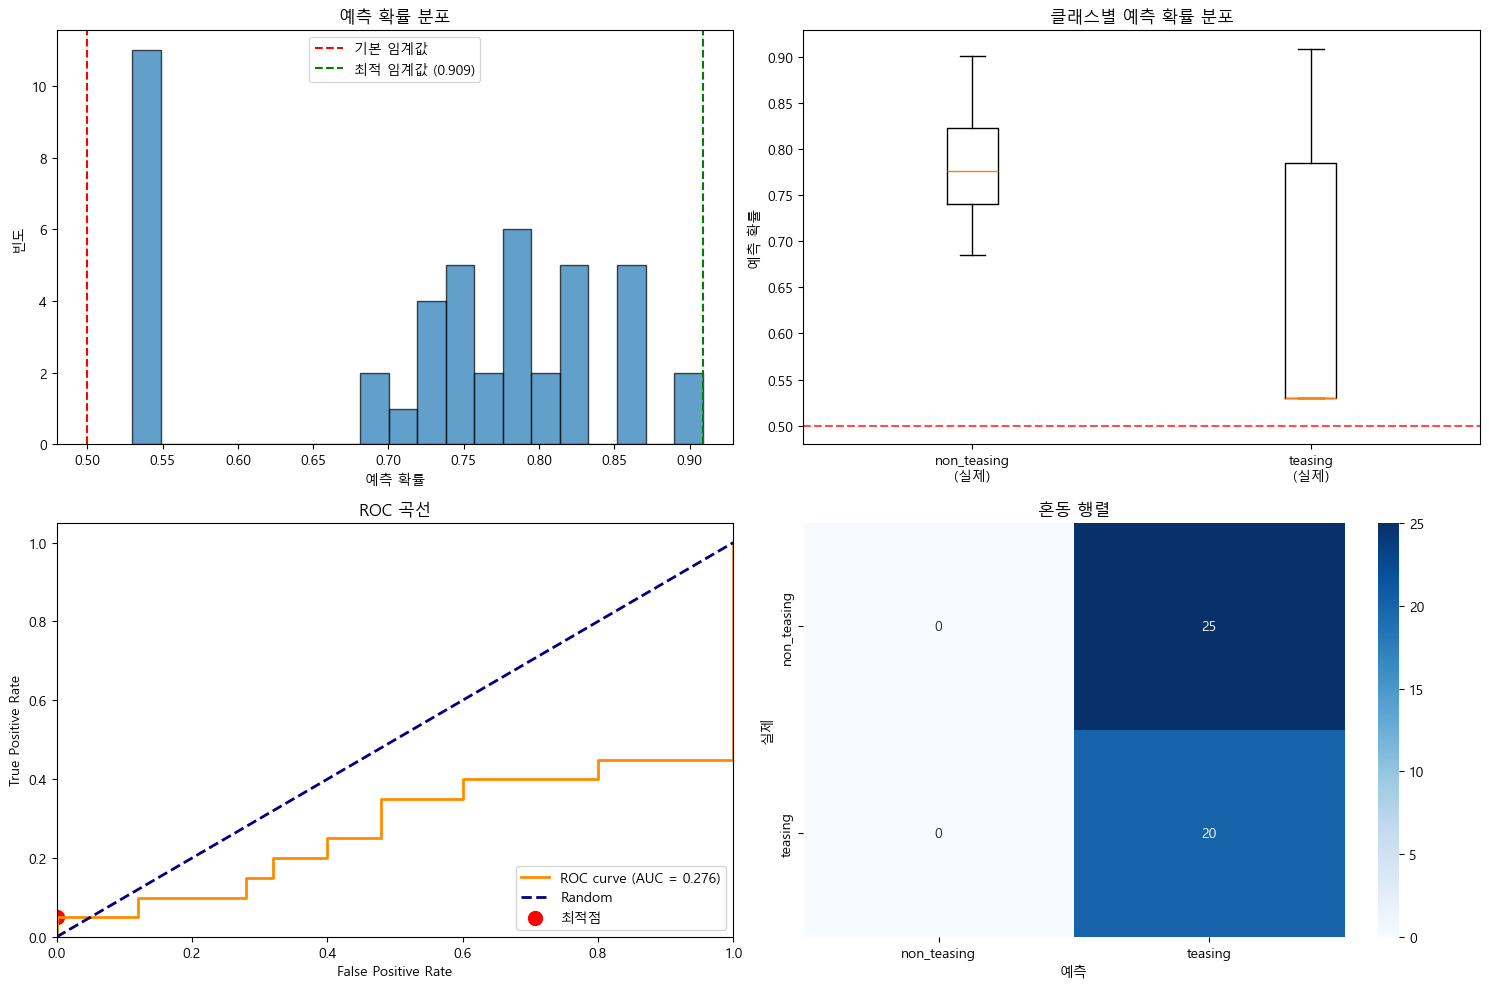

üéâ ÏãúÎèô ÏÑ±Í≥µ! Î™®Îç∏Ïù¥ Ï†ïÏÉÅÏ†ÅÏúºÎ°ú ÏûëÎèôÌï©ÎãàÎã§!


In [68]:
import matplotlib.pyplot as plt

print("=== üìà ÏÑ±Îä• ÏãúÍ∞ÅÌôî ===")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. ÏòàÏ∏° ÌôïÎ•† ÌûàÏä§ÌÜ†Í∑∏Îû®
axes[0,0].hist(y_pred_prob_final, bins=20, alpha=0.7, edgecolor='black')
axes[0,0].axvline(x=0.5, color='red', linestyle='--', label='Í∏∞Î≥∏ ÏûÑÍ≥ÑÍ∞í')
axes[0,0].axvline(x=optimal_threshold, color='green', linestyle='--', label=f'ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í ({optimal_threshold:.3f})')
axes[0,0].set_title('ÏòàÏ∏° ÌôïÎ•† Î∂ÑÌè¨')
axes[0,0].set_xlabel('ÏòàÏ∏° ÌôïÎ•†')
axes[0,0].set_ylabel('ÎπàÎèÑ')
axes[0,0].legend()

# 2. ÌÅ¥ÎûòÏä§Î≥Ñ ÏòàÏ∏° ÌôïÎ•† Î∞ïÏä§ÌîåÎ°Ø
data_to_plot = [non_teasing_probs, teasing_probs]
axes[0,1].boxplot(data_to_plot, labels=['non_teasing\n(Ïã§Ï†ú)', 'teasing\n(Ïã§Ï†ú)'])
axes[0,1].axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
axes[0,1].set_title('ÌÅ¥ÎûòÏä§Î≥Ñ ÏòàÏ∏° ÌôïÎ•† Î∂ÑÌè¨')
axes[0,1].set_ylabel('ÏòàÏ∏° ÌôïÎ•†')

# 3. ROC Í≥°ÏÑ†
axes[1,0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1,0].scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, label=f'ÏµúÏ†ÅÏ†ê')
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Í≥°ÏÑ†')
axes[1,0].legend(loc="lower right")

# 4. ÌòºÎèô ÌñâÎ†¨ ÌûàÌä∏Îßµ
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['non_teasing', 'teasing'],
            yticklabels=['non_teasing', 'teasing'],
            ax=axes[1,1])
axes[1,1].set_title('ÌòºÎèô ÌñâÎ†¨')
axes[1,1].set_xlabel('ÏòàÏ∏°')
axes[1,1].set_ylabel('Ïã§Ï†ú')

plt.tight_layout()
plt.show()

print("üéâ ÏãúÎèô ÏÑ±Í≥µ! Î™®Îç∏Ïù¥ Ï†ïÏÉÅÏ†ÅÏúºÎ°ú ÏûëÎèôÌï©ÎãàÎã§!")